## Preprocessing 2
### Change to grayscale

In [31]:
import pickle
import tensorflow as tf
import numpy as np
# download pickle from here https://drive.google.com/drive/folders/1IretnUcTy5ps4kJ9KaW4E-KsBwASfL6P
# Put on ./Data/ folder
x_train_in = open('./Data/X_train_balanced.pickle','rb')
y_train_in = open('./Data/y_train_balanced.pickle','rb')
x_val_in = open('./Data/X_val.pickle','rb')
y_val_in = open('./Data/y_val.pickle','rb')
x_test_in = open('./Data/X_test.pickle','rb')
y_test_in = open('./Data/y_test.pickle','rb')

In [32]:
x_train = pickle.load(x_train_in)
y_train = pickle.load(y_train_in)
x_val = pickle.load(x_val_in)
y_val = pickle.load(y_val_in)
x_test = pickle.load(x_test_in)
y_test = pickle.load(y_test_in)
del x_train_in, y_train_in, x_val_in, y_val_in, x_test_in, y_test_in

In [33]:
from tensorflow.keras.utils import to_categorical
def reshapeToFloat(ndarrays):
    return ndarrays.reshape(-1, 250, 250, 3).astype('float32') / 255.

def reshapeToCategorical(ndarrays):
    return to_categorical(ndarrays.astype('float32'))

In [34]:
x_train = reshapeToFloat(x_train)
x_test = reshapeToFloat(x_test)
x_val = reshapeToFloat(x_val)

y_train = reshapeToCategorical(y_train)
y_test = reshapeToCategorical(y_test)
y_val = reshapeToCategorical(y_val)


In [35]:
tf.print(tf.reduce_sum(y_train))
print(x_train.shape)

2682
(2682, 250, 250, 3)


In [36]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).reshape(-1, 250, 250, 1) #rumus grayscale

x_train, x_test, x_val = rgb2gray(x_train), rgb2gray(x_test), rgb2gray(x_val)

In [37]:
tf.print(tf.reduce_sum(y_train))
print(x_train.shape)

2682
(2682, 250, 250, 1)


In [42]:
# save pickle
def saveAsPickle(data, name):
    pickle_out = open("./Data/"+name,"wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

#Save as float64 makanya gede sizenya
saveAsPickle(x_train, 'x_train_balanced_grayscale.pickle')
saveAsPickle(x_test, 'x_test_grayscale.pickle')
saveAsPickle(x_val, 'x_val_grayscale.pickle')



In [43]:
saveAsPickle(y_train, 'y_train_balanced_grayscale.pickle')
saveAsPickle(y_test, 'y_test_grayscale.pickle')
saveAsPickle(y_val, 'y_val_grayscale.pickle')

## Load Grayscale and Categorical Data

In [1]:
import pickle
import tensorflow as tf
import numpy as np
x_train_in = open('./Data/x_train_balanced_grayscale.pickle','rb')
y_train_in = open('./Data/y_train_balanced_grayscale.pickle','rb')
x_val_in = open('./Data/x_val_grayscale.pickle','rb')
y_val_in = open('./Data/y_val_grayscale.pickle','rb')
x_test_in = open('./Data/x_test_grayscale.pickle','rb')
y_test_in = open('./Data/y_test_grayscale.pickle','rb')

x_train = pickle.load(x_train_in).astype('float32')
y_train = pickle.load(y_train_in).astype('float32')
x_val = pickle.load(x_val_in).astype('float32')
y_val = pickle.load(y_val_in).astype('float32')
x_test = pickle.load(x_test_in).astype('float32')
y_test = pickle.load(y_test_in).astype('float32')
del x_train_in, y_train_in, x_val_in, y_val_in, x_test_in, y_test_in

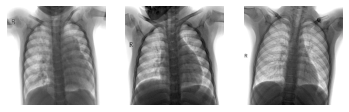

In [2]:
import matplotlib.pyplot as plt
n_samples = 3

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_train[index].reshape(250, 250)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

## Creating Network
### Defining Classes

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding, name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [4]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

# Parameters
BATCH_SIZE = 8                #149 * 18 = 2682
n_class = 2                         #DigiCaps {Normal, Pneumonia}
routings = 3                        #Default from Paper
input_shape = x_train.shape[1:]

In [5]:
x = layers.Input(shape=input_shape, batch_size=BATCH_SIZE)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=32, kernel_size=25, strides=5, padding='valid', activation='relu', name='conv1')(x)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=4, n_channels=16, kernel_size=25, strides=5, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = layers.Input(shape=(n_class,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(256, activation='relu', input_dim=16 * n_class))
decoder.add(layers.Dense(512, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model = models.Model(x, [out_caps, decoder(masked)])


In [6]:
train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(8, 250, 250, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (8, 46, 46, 32)      20032       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (8, 5, 5, 64)        1280064     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (8, 400, 4)          0           primarycap_conv2d[0][0]          
______________________________________________________________________________________________

In [7]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [8]:
lr_decay = 0.9
lr = 0.001
lam_recon = 0.392
epochs = 10

# compile the model
train_model.compile(optimizer=optimizers.Adam(lr=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})

In [9]:
type(x_train[0,0,0,0])


numpy.float32

In [10]:
train_model.fit([x_train, y_train], [y_train, x_train], batch_size=BATCH_SIZE, epochs=epochs, validation_data=[[x_val, y_val], [y_val, x_val]])

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv1/Conv2D (defined at <ipython-input-10-83505e03a78e>:1) ]] [Op:__inference_train_function_3107]

Function call stack:
train_function


In [11]:
# train_model.save('./train_model')
# eval_model.save('./eval_model')

In [12]:
# y_pred, x_recon = eval_model.predict(x_test, batch_size=100)
# print('-' * 30 + 'Begin: test' + '-' * 30)
# print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

In [13]:
import math
def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [14]:
# img = combine_images(np.concatenate([x_test[:50], x_recon[:50]]))
# image = img * 255
# Image.fromarray(image.astype(np.uint8)).save("reconstruction/real_and_recon.png")
# print()
# print('-' * 30 + 'End: test' + '-' * 30)
# plt.imshow(plt.imread("reconstruction/real_and_recon.png"))
# plt.show()